Transformed Sectiontion Method
- "Its core principle involves conceptually converting the multi-material cross-section of a layered beam into an equivalent, fictitious cross-section composed entirely of a single, homogeneous material."
- "The transformation is achieved by adjusting the width of each material by a factor equal to its modular ratio (n_i = E_i / E_ref), relative to the chosen base material."

(hand hardness, grain form) -> density
density -> Youngs Modulus
(Young's Modulus, thickness, orientation) -> Bending stiffness

In [ ]:
# Calculate density from hand hardness and grain form

# Calculate Young's Modulus from density

# Select Reference Material in Slab (highest E)

# Calculate modular ratio for each layer

# Transform width of each layer by modular ratio

# Locate Centroid of Layer

# Locate Centroid of Transformed slab

# Calculate Moment of Inertia (I) of the Transformed Slab

# Calculate Equivalent Bending Stiffness (D11) of the Transformed Slab


Goal: Violin plots of the following data

Y-axis (1 plot for each variable): Weight, Bending Stiffness (D11) above "weak layer"
    Weak Layer is: 
    - Failure layer of test (ECT, PST)
    - failure layer of avalanche (Crown, flank)
    - or identified layer of concern (Layer of concern)

X-axis: Different groups of pits
    - ECTP
    - ECTN
    - PST < 0.5
    - Pits on crowns
    - Pits on flanks
    - Layer of concern


Larger dataset
- Last five snow years


Need to code

Weight
- Density from hand hardness and grain form
- Weight above weak layer (from layer densities and thickensses)

Bending stiffness
- Elastic modulus (p 1481)
    

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowpylot import caaml_parser


parse_pits function: Parses all pits in a specified folder

In [58]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list


Specify folders for 2020-2024 Water Years and parse files

In [59]:
# Define folders and parse pits

pits_19_20 = parse_pits("../snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("../snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("../snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("../snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("../snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits


Geldsetzer table of density from hand hardness and grain form

In [60]:
geldsetzer_df = pd.read_csv('geldsetzer_table.csv', index_col=0)

def get_density(hand_hardness, grain_form, df=geldsetzer_df):
    """
    Get density value for a specific hand hardness and grain form combination.
    
    Parameters:
    df (pd.DataFrame): The Geldsetzer table DataFrame
    hand_hardness (str): Hand hardness value (e.g., 'F-', '4F+', 'P-', etc.)
    grain_form (str): Grain form (e.g., 'PP', 'DF', 'RG', 'FC', 'DH', etc.)
    
    Returns:
    float: Density value, or NaN if not available
    """
    try:
        return df.loc[hand_hardness, grain_form]
    except KeyError as e:
        print(f"Key not found: {e}")
        return np.nan

def convert_grain_form(layer):
    """
    Convert grain form to code needed for Geldsetzer table.
    
    Parameters:
    layer: Snow layer object with grain_form_primary attribute
    
    Returns:
    str: Grain form code for Geldsetzer table lookup
    """
    if layer.grain_form_primary.sub_grain_class_code in ["PPgp","RGmx","FCmx"]:
        return layer.grain_form_primary.sub_grain_class_code
    else:
        return layer.grain_form_primary.basic_grain_class_code

def calculate_weight_above_layer(layers, target_layer):
    """
    Calculate cumulative weight above a specified target layer.
    FIXED: Now correctly calculates weight ABOVE the target layer (excludes target layer).
    
    Parameters:
    layers: List of snow layer objects
    target_layer: The layer to stop calculation at (weight calculated above this layer)
    
    Returns:
    float: Weight above target layer in kg/m², or NaN if calculation fails
    """
    weight_above = 0
    target_found = False
    
    for layer in layers:
        # Check if we've reached the target layer - if so, stop BEFORE including it
        if layer is target_layer:
            target_found = True
            break
            
        # Convert grain form to code needed for Geldsetzer table
        grain_form = convert_grain_form(layer)
        
        # Get density
        density = get_density(layer.hardness, grain_form)
        
        if pd.isna(density):
            return np.nan
            
        # Calculate weight
        thickness_m = (layer.thickness[0])/100  # convert cm to m
        weight = thickness_m * density  # Weight in kg (assuming 1 m^2 cross-section)
        weight_above += weight
    
    # If target layer was not found, return NaN
    if not target_found:
        return np.nan
        
    return weight_above

def calculate_bending_stiffness(layers, target_layer):
    """
    Calculate bending stiffness above a specified target layer.
    
    Parameters:
    layers: List of snow layer objects
    target_layer: The layer to stop calculation at (bending stiffness calculated above this layer)
    """

    return

def filter_pits_with_hardness_and_grain_form(pits):
    """
    Filter pits to only include those with complete hardness and grain form data.
    
    Parameters:
    pits: List of pit objects
    
    Returns:
    list: Filtered list of pits with complete data
    """
    filtered_pits = []
    
    for pit in pits:
        all_layers_info = True
        layers = pit.snow_profile.layers
        for layer in layers:
            if layer.hardness is None or layer.grain_form_primary is None:
                all_layers_info = False
                break
        if all_layers_info:
            filtered_pits.append(pit)
            
    return filtered_pits

def filter_pits_with_layer_of_concern(pits):
    """
    Filter pits to only include those with at least one layer of concern.
    
    Parameters:
    pits: List of pit objects
    
    Returns:
    list: Filtered list of pits with layer of concern
    """
    filtered_pits = []
    
    for pit in pits:
        layers = pit.snow_profile.layers
        has_loc = any(layer.layer_of_concern for layer in layers)
        if has_loc:
            filtered_pits.append(pit)
            
    return filtered_pits

def calculate_weights_for_layer_of_concern(pits):
    """
    Calculate weight above layer of concern for a list of pits.
    
    Parameters:
    pits: List of pit objects with layer of concern
    
    Returns:
    list: List of dictionaries with pit_id and weight_above_layer_of_concern
    """
    results = []
    
    for pit in pits:
        layers = pit.snow_profile.layers
        target_layer = None
        
        # Find the layer of concern
        for layer in layers:
            if layer.layer_of_concern:
                target_layer = layer
                break
                
        if target_layer is not None:
            weight_above = calculate_weight_above_layer(layers, target_layer)
            pit_info = {
                "pit_id": pit.core_info.pit_id,
                "weight_above_layer_of_concern": weight_above
            }
            results.append(pit_info)
            
    return results

def print_weight_statistics(df, weight_column, description):
    """
    Print summary statistics for weight data.
    
    Parameters:
    df: DataFrame containing weight data
    weight_column: Name of the weight column
    description: Description for the output
    """
    non_nan_results = df[df[weight_column].notna()]
    print(f"num pits with {description}: {len(non_nan_results)}")
    print(f"mean {description} (kg): {non_nan_results[weight_column].mean()}")
    print(f"median {description} (kg): {non_nan_results[weight_column].median()}")
    print()

def calculate_weights_for_ECTP_propagation(pits):
    """
    Calculate weight above ECTP propagation layer for a list of pits.
    
    Parameters:
    pits: List of pit objects
    
    Returns:
    list: List of dictionaries with pit_id and weight_above_ECTP_layer_of_propagation
    """
    results = []
    
    for pit in pits:
        ECTs_list = pit.stability_tests.ECT  # list of ECTs for pit
        layers = pit.snow_profile.layers  # List of layers in pit
        
        for ECT in ECTs_list:  # For each ECT in pit
            if ECT.propagation:  # If ECTP
                prop_layer_depth_top = ECT.depth_top  # depth of top of propagation layer 
                prop_layer = None      
                
                # Find the layer of propagation in layers
                for layer in layers:
                    if layer.depth_top == prop_layer_depth_top:
                        prop_layer = layer
                        break
                        
                if prop_layer is not None:  # If layer of propagation is found in snow_profile
                    weight_above = calculate_weight_above_layer(layers, prop_layer)
                    
                    if not pd.isna(weight_above):
                        pit_info = {
                            "pit_id": pit.core_info.pit_id,
                            "weight_above_ECTP_layer_of_propagation": weight_above
                        }
                        results.append(pit_info)
                        
    return results

def filter_pits_by_location(pits, location_type):
    """
    Filter pits by avalanche location type (crown or flank).
    
    Parameters:
    pits: List of pit objects
    location_type: String, either "crown" or "flank"
    
    Returns:
    list: Filtered list of pits at specified location
    """
    filtered_pits = []
    
    for pit in pits:
        if pit.core_info.location.pit_near_avalanche_location == location_type:
            filtered_pits.append(pit)
            
    return filtered_pits

def prepare_plotting_data(dataframes_and_labels):
    """
    Prepare multiple dataframes for plotting by combining them with labels.
    
    Parameters:
    dataframes_and_labels: List of tuples, each containing (dataframe, weight_column, label)
    
    Returns:
    pd.DataFrame: Combined dataframe ready for plotting
    """
    combined_data = []
    
    for df, weight_column, label in dataframes_and_labels:
        clean_df = df[df[weight_column].notna()].copy()
        clean_df['dataset'] = label
        clean_df['weight'] = clean_df[weight_column]
        combined_data.append(clean_df[['dataset', 'weight']])
    
    return pd.concat(combined_data, ignore_index=True)


## Find Pits with Hand Hardness and Grain Form



In [61]:
# Find pits with hardness and grain form info
pits_with_hardness_and_grain_form = filter_pits_with_hardness_and_grain_form(all_pits)

print("Num pits with hardness and grain form info: ", len(pits_with_hardness_and_grain_form))


Num pits with hardness and grain form info:  12466


Find weight above indicated layer of concern

In [62]:
# Find pits with indicated layer of concern
pits_with_layer_of_concern = filter_pits_with_layer_of_concern(pits_with_hardness_and_grain_form)

print("Num pits: ", len(all_pits))
print("Num pits with hand hardness and grain form, and layer of concern: ", len(pits_with_layer_of_concern))


Num pits:  31170
Num pits with hand hardness and grain form, and layer of concern:  9316


In [63]:
LOC_results = calculate_weights_for_layer_of_concern(pits_with_layer_of_concern)
LOC_results_df = pd.DataFrame(LOC_results)


Key not found: 'IF'
Key not found: 'MF'
Key not found: None
Key not found: 'IF'
Key not found: None
Key not found: 'MF'
Key not found: None
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'IF'
Key not found: None
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'


In [64]:
print_weight_statistics(LOC_results_df, 'weight_above_layer_of_concern', 'weight above layer of concern')


num pits with weight above layer of concern: 5249
mean weight above layer of concern (kg): 74.51325662030864
median weight above layer of concern (kg): 55.68



### Weight Above ECTP Layer of Propagation

In [65]:
ECTP_results = calculate_weights_for_ECTP_propagation(pits_with_hardness_and_grain_form)
ECTP_results_df = pd.DataFrame(ECTP_results)


Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: None
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'


In [66]:
print_weight_statistics(ECTP_results_df, 'weight_above_ECTP_layer_of_propagation', 'weight above ECTP layer of propagation')


num pits with weight above ECTP layer of propagation: 1368
mean weight above ECTP layer of propagation (kg): 79.13145175438596
median weight above ECTP layer of propagation (kg): 67.84



## Layer of Concern for Pits on Crowns and Flanks

In [67]:
pits_on_crowns = filter_pits_by_location(pits_with_hardness_and_grain_form, "crown")
pits_on_flanks = filter_pits_by_location(pits_with_hardness_and_grain_form, "flank")

print("num pits on crowns (with hand hardness and grain form): ", len(pits_on_crowns))
print("num pits on flanks (with hand hardness and grain form): ", len(pits_on_flanks))
    

num pits on crowns (with hand hardness and grain form):  187
num pits on flanks (with hand hardness and grain form):  93


In [68]:
# Pits on crowns with LOC
pits_on_crowns_with_LOC = filter_pits_with_layer_of_concern(pits_on_crowns)

# Pits on flanks with LOC
pits_on_flanks_with_LOC = filter_pits_with_layer_of_concern(pits_on_flanks)

print("num pits on crowns (with LOC): ", len(pits_on_crowns_with_LOC))
print("num pits on flanks (with LOC): ", len(pits_on_flanks_with_LOC))


num pits on crowns (with LOC):  172
num pits on flanks (with LOC):  80


In [69]:
# Calculate weight above LOC for pits on crowns and flanks

# Pits on crowns with LOC
pits_on_crowns_with_LOC_results = calculate_weights_for_layer_of_concern(pits_on_crowns_with_LOC)
pits_on_crowns_with_LOC_results_df = pd.DataFrame(pits_on_crowns_with_LOC_results)

# Pits on flanks with LOC
pits_on_flanks_with_LOC_results = calculate_weights_for_layer_of_concern(pits_on_flanks_with_LOC)
pits_on_flanks_with_LOC_results_df = pd.DataFrame(pits_on_flanks_with_LOC_results)


Key not found: 'SH'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: None
Key not found: 'MF'
Key not found: 'MF'
Key not found: None
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'


In [70]:
# Summary Stats for pits_on_crowns_with_LOC_results
print("Crown pits:")
print_weight_statistics(pits_on_crowns_with_LOC_results_df, 'weight_above_layer_of_concern', 'weight above layer of concern')

# Summary Stats for pits_on_flanks_with_LOC_results  
print("Flank pits:")
print_weight_statistics(pits_on_flanks_with_LOC_results_df, 'weight_above_layer_of_concern', 'weight above layer of concern')


Crown pits:
num pits with weight above layer of concern: 115
mean weight above layer of concern (kg): 105.86826086956522
median weight above layer of concern (kg): 88.4

Flank pits:
num pits with weight above layer of concern: 45
mean weight above layer of concern (kg): 86.5811111111111
median weight above layer of concern (kg): 68.57000000000001



# Plot Results

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_7362/1232855539.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=combined_df, x='dataset', y='weight', palette='Set2')


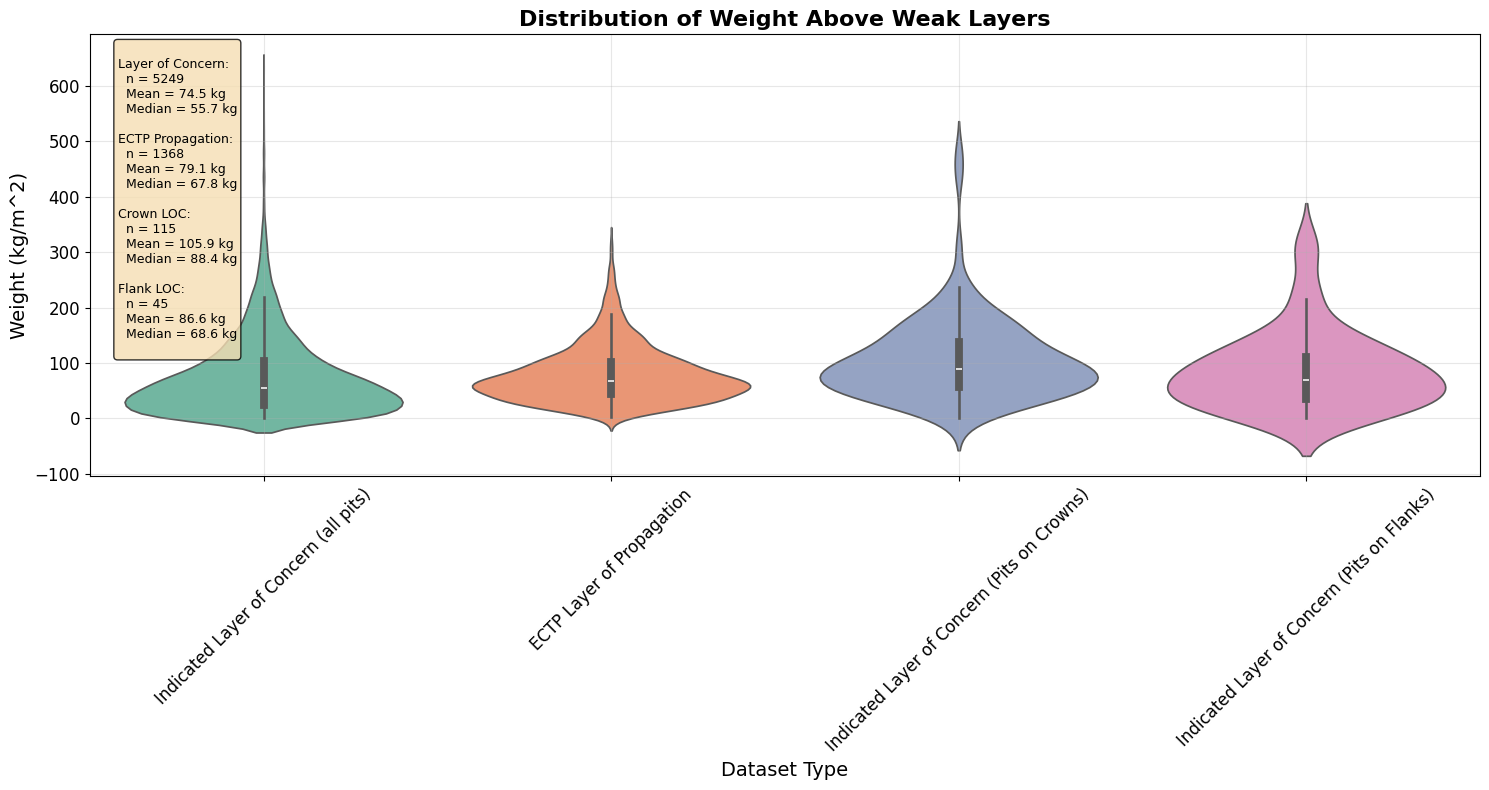

Summary Statistics:
Layer of Concern - Count: 5249, Mean: 74.5 kg, Median: 55.7 kg
ECTP Propagation - Count: 1368, Mean: 79.1 kg, Median: 67.8 kg
Crown LOC - Count: 115, Mean: 105.9 kg, Median: 88.4 kg
Flank LOC - Count: 45, Mean: 86.6 kg, Median: 68.6 kg


In [71]:
# Create side-by-side violin plots for LOC, ECTP, Crown, and Flank results

# Prepare the data for plotting using the helper function
data_for_plotting = [
    (LOC_results_df, 'weight_above_layer_of_concern', 'Indicated Layer of Concern (all pits)'),
    (ECTP_results_df, 'weight_above_ECTP_layer_of_propagation', 'ECTP Layer of Propagation'),
    (pits_on_crowns_with_LOC_results_df, 'weight_above_layer_of_concern', 'Indicated Layer of Concern (Pits on Crowns)'),
    (pits_on_flanks_with_LOC_results_df, 'weight_above_layer_of_concern', 'Indicated Layer of Concern (Pits on Flanks)')
]

combined_df = prepare_plotting_data(data_for_plotting)

# Create the violin plot
plt.figure(figsize=(15, 8))
ax = sns.violinplot(data=combined_df, x='dataset', y='weight', palette='Set2')

# Customize the plot
plt.title('Distribution of Weight Above Weak Layers', fontsize=16, fontweight='bold')
plt.xlabel('Dataset Type', fontsize=14)
plt.ylabel('Weight (kg/m^2)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add statistical information as text
# Get clean data for statistics
LOC_clean = LOC_results_df[LOC_results_df['weight_above_layer_of_concern'].notna()]
ECTP_clean = ECTP_results_df[ECTP_results_df['weight_above_ECTP_layer_of_propagation'].notna()]
Crown_clean = pits_on_crowns_with_LOC_results_df[pits_on_crowns_with_LOC_results_df['weight_above_layer_of_concern'].notna()]
Flank_clean = pits_on_flanks_with_LOC_results_df[pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'].notna()]

stats_text = f"""
Layer of Concern:
  n = {len(LOC_clean)}
  Mean = {LOC_clean['weight_above_layer_of_concern'].mean():.1f} kg
  Median = {LOC_clean['weight_above_layer_of_concern'].median():.1f} kg

ECTP Propagation:
  n = {len(ECTP_clean)}
  Mean = {ECTP_clean['weight_above_ECTP_layer_of_propagation'].mean():.1f} kg
  Median = {ECTP_clean['weight_above_ECTP_layer_of_propagation'].median():.1f} kg

Crown LOC:
  n = {len(Crown_clean)}
  Mean = {Crown_clean['weight_above_layer_of_concern'].mean():.1f} kg
  Median = {Crown_clean['weight_above_layer_of_concern'].median():.1f} kg

Flank LOC:
  n = {len(Flank_clean)}
  Mean = {Flank_clean['weight_above_layer_of_concern'].mean():.1f} kg
  Median = {Flank_clean['weight_above_layer_of_concern'].median():.1f} kg
"""

plt.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Layer of Concern - Count: {len(LOC_clean)}, Mean: {LOC_clean['weight_above_layer_of_concern'].mean():.1f} kg, Median: {LOC_clean['weight_above_layer_of_concern'].median():.1f} kg")
print(f"ECTP Propagation - Count: {len(ECTP_clean)}, Mean: {ECTP_clean['weight_above_ECTP_layer_of_propagation'].mean():.1f} kg, Median: {ECTP_clean['weight_above_ECTP_layer_of_propagation'].median():.1f} kg")
print(f"Crown LOC - Count: {len(Crown_clean)}, Mean: {Crown_clean['weight_above_layer_of_concern'].mean():.1f} kg, Median: {Crown_clean['weight_above_layer_of_concern'].median():.1f} kg")
print(f"Flank LOC - Count: {len(Flank_clean)}, Mean: {Flank_clean['weight_above_layer_of_concern'].mean():.1f} kg, Median: {Flank_clean['weight_above_layer_of_concern'].median():.1f} kg")


In [72]:
# Debug: Let's examine the weight calculation logic and find negative values
print("=== DEBUGGING NEGATIVE WEIGHT VALUES ===")

# First, let's look at the Flank_clean data to see if there are actually negative values
print(f"Flank_clean shape: {pits_on_flanks_with_LOC_results_df.shape}")
print(f"Number of non-null weight values: {pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'].notna().sum()}")

# Check for negative values
negative_weights = pits_on_flanks_with_LOC_results_df[pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'] < 0]
print(f"Number of negative weight values: {len(negative_weights)}")

if len(negative_weights) > 0:
    print("Negative weight values found:")
    print(negative_weights[['pit_id', 'weight_above_layer_of_concern']])
    
    # Let's examine the first negative case in detail
    first_negative_pit_id = negative_weights.iloc[0]['pit_id']
    print(f"\nExamining pit {first_negative_pit_id} in detail...")
    
    # Find this pit in the original data
    problem_pit = None
    for pit in pits_on_flanks_with_LOC:
        if pit.core_info.pit_id == first_negative_pit_id:
            problem_pit = pit
            break
    
    if problem_pit:
        layers = problem_pit.snow_profile.layers
        print(f"Number of layers: {len(layers)}")
        
        # Find the layer of concern
        target_layer = None
        for i, layer in enumerate(layers):
            if layer.layer_of_concern:
                target_layer = layer
                print(f"Layer of concern found at index {i}")
                print(f"Layer depth_top: {layer.depth_top}")
                print(f"Layer thickness: {layer.thickness}")
                print(f"Layer hardness: {layer.hardness}")
                print(f"Layer grain form: {layer.grain_form_primary.basic_grain_class_code if layer.grain_form_primary else None}")
                break
        
        if target_layer:
            print(f"\nLayer structure:")
            for i, layer in enumerate(layers):
                grain_form = convert_grain_form(layer) if layer.grain_form_primary else "Unknown"
                density = get_density(layer.hardness, grain_form) if layer.hardness else "Unknown"
                print(f"Layer {i}: depth_top={layer.depth_top}, thickness={layer.thickness}, hardness={layer.hardness}, grain_form={grain_form}, density={density}")
                if layer is target_layer:
                    print(f"  *** This is the layer of concern ***")
else:
    print("No negative weight values found in the data.")


=== DEBUGGING NEGATIVE WEIGHT VALUES ===
Flank_clean shape: (80, 2)
Number of non-null weight values: 45
Number of negative weight values: 0
No negative weight values found in the data.


In [73]:
# Let's create a corrected version of the calculate_weight_above_layer function
def calculate_weight_above_layer_corrected(layers, target_layer):
    """
    Calculate cumulative weight above a specified target layer.
    CORRECTED VERSION: Only includes layers ABOVE the target layer.
    
    Parameters:
    layers: List of snow layer objects
    target_layer: The layer to stop calculation at (weight calculated above this layer)
    
    Returns:
    float: Weight above target layer in kg/m², or NaN if calculation fails
    """
    weight_above = 0
    target_found = False
    
    for layer in layers:
        # Check if we've reached the target layer - if so, stop BEFORE including it
        if layer is target_layer:
            target_found = True
            break
            
        # Convert grain form to code needed for Geldsetzer table
        grain_form = convert_grain_form(layer)
        
        # Get density
        density = get_density(layer.hardness, grain_form)
        
        if pd.isna(density):
            return np.nan
            
        # Calculate weight
        thickness_m = (layer.thickness[0])/100  # convert cm to m
        weight = thickness_m * density  # Weight in kg (assuming 1 m^2 cross-section)
        weight_above += weight
    
    # If target layer was not found, return NaN
    if not target_found:
        print(f"Warning: Target layer not found in layers list")
        return np.nan
        
    return weight_above

# Test the corrected function on a few examples
print("\\n=== TESTING CORRECTED FUNCTION ===")

# Test on the same negative weight cases
if len(negative_weights) > 0:
    for idx, row in negative_weights.head(3).iterrows():  # Test first 3 negative cases
        pit_id = row['pit_id']
        original_weight = row['weight_above_layer_of_concern']
        
        # Find the pit
        test_pit = None
        for pit in pits_on_flanks_with_LOC:
            if pit.core_info.pit_id == pit_id:
                test_pit = pit
                break
        
        if test_pit:
            layers = test_pit.snow_profile.layers
            target_layer = None
            for layer in layers:
                if layer.layer_of_concern:
                    target_layer = layer
                    break
            
            if target_layer:
                corrected_weight = calculate_weight_above_layer_corrected(layers, target_layer)
                print(f"Pit {pit_id}: Original={original_weight:.2f}, Corrected={corrected_weight:.2f}")
else:
    print("No negative weights to test corrected function on.")


\n=== TESTING CORRECTED FUNCTION ===
No negative weights to test corrected function on.


In [74]:
# Let's check the RAW dataframe before filtering for negative values
print("=== CHECKING RAW DATA BEFORE FILTERING ===")

print(f"Raw pits_on_flanks_with_LOC_results_df shape: {pits_on_flanks_with_LOC_results_df.shape}")
print(f"Number of total weight values: {len(pits_on_flanks_with_LOC_results_df)}")
print(f"Number of non-null weight values: {pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'].notna().sum()}")
print(f"Number of null weight values: {pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'].isna().sum()}")

# Check for negative values in the RAW data
raw_negative_weights = pits_on_flanks_with_LOC_results_df[pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'] < 0]
print(f"Number of negative weight values in RAW data: {len(raw_negative_weights)}")

# Check all weight values
weight_values = pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern']
print(f"Weight value statistics:")
print(f"  Min: {weight_values.min()}")
print(f"  Max: {weight_values.max()}")
print(f"  Mean: {weight_values.mean()}")
print(f"  Median: {weight_values.median()}")

# Show the distribution of values
print(f"\nWeight value distribution:")
print(weight_values.describe())

# Also check if there are any zero values
zero_weights = pits_on_flanks_with_LOC_results_df[pits_on_flanks_with_LOC_results_df['weight_above_layer_of_concern'] == 0]
print(f"Number of zero weight values: {len(zero_weights)}")

# Let's also check all other datasets for negative values
print(f"\n=== CHECKING OTHER DATASETS FOR NEGATIVE VALUES ===")

# Check LOC_results_df
loc_negative = LOC_results_df[LOC_results_df['weight_above_layer_of_concern'] < 0]
print(f"LOC_results_df negative values: {len(loc_negative)}")
if len(loc_negative) > 0:
    print(f"  Min negative value: {loc_negative['weight_above_layer_of_concern'].min()}")

# Check ECTP_results_df
ectp_negative = ECTP_results_df[ECTP_results_df['weight_above_ECTP_layer_of_propagation'] < 0]
print(f"ECTP_results_df negative values: {len(ectp_negative)}")
if len(ectp_negative) > 0:
    print(f"  Min negative value: {ectp_negative['weight_above_ECTP_layer_of_propagation'].min()}")

# Check Crown data
crown_negative = pits_on_crowns_with_LOC_results_df[pits_on_crowns_with_LOC_results_df['weight_above_layer_of_concern'] < 0]
print(f"Crown data negative values: {len(crown_negative)}")
if len(crown_negative) > 0:
    print(f"  Min negative value: {crown_negative['weight_above_layer_of_concern'].min()}")


=== CHECKING RAW DATA BEFORE FILTERING ===
Raw pits_on_flanks_with_LOC_results_df shape: (80, 2)
Number of total weight values: 80
Number of non-null weight values: 45
Number of null weight values: 35
Number of negative weight values in RAW data: 0
Weight value statistics:
  Min: 0.0
  Max: 320.82
  Mean: 86.58111111111111
  Median: 68.57000000000001

Weight value distribution:
count     45.000000
mean      86.581111
std       72.192777
min        0.000000
25%       35.880000
50%       68.570000
75%      111.300000
max      320.820000
Name: weight_above_layer_of_concern, dtype: float64
Number of zero weight values: 1

=== CHECKING OTHER DATASETS FOR NEGATIVE VALUES ===
LOC_results_df negative values: 0
ECTP_results_df negative values: 0
Crown data negative values: 0


In [75]:
# Let's analyze the actual weight calculation logic issue
print("=== ANALYZING WEIGHT CALCULATION LOGIC ===")

# The issue is in the calculate_weight_above_layer function logic
# Let's test the original vs corrected function on a few examples

def test_weight_calculation_logic():
    """Test to demonstrate the logical issue in the original function"""
    
    # Find a pit with layer of concern to test on
    test_pit = None
    for pit in pits_on_flanks_with_LOC[:5]:  # Test first 5 pits
        if pit is not None:
            test_pit = pit
            break
    
    if test_pit:
        layers = test_pit.snow_profile.layers
        target_layer = None
        
        # Find the layer of concern
        for layer in layers:
            if layer.layer_of_concern:
                target_layer = layer
                break
        
        if target_layer and layers:
            print(f"Testing on pit {test_pit.core_info.pit_id}:")
            print(f"Number of layers: {len(layers)}")
            
            # Show layer structure
            print("Layer structure (from top to bottom):")
            for i, layer in enumerate(layers):
                is_target = " ← TARGET LAYER" if layer is target_layer else ""
                grain_form = convert_grain_form(layer) if layer.grain_form_primary else "Unknown"
                density = get_density(layer.hardness, grain_form) if layer.hardness else "N/A"
                thickness = layer.thickness[0] if layer.thickness else "N/A"
                print(f"  Layer {i}: depth={layer.depth_top}cm, thickness={thickness}cm, density={density}kg/m³{is_target}")
            
            # Test original function
            original_weight = calculate_weight_above_layer(layers, target_layer)
            print(f"\\nOriginal function result: {original_weight:.2f} kg" if not pd.isna(original_weight) else "Original function result: NaN")
            
            # Test corrected function
            corrected_weight = calculate_weight_above_layer_corrected(layers, target_layer)
            print(f"Corrected function result: {corrected_weight:.2f} kg" if not pd.isna(corrected_weight) else "Corrected function result: NaN")
            
            if not pd.isna(original_weight) and not pd.isna(corrected_weight):
                difference = original_weight - corrected_weight
                print(f"Difference (Original - Corrected): {difference:.2f} kg")
                
                if abs(difference) > 0.01:  # If there's a significant difference
                    print("\\n*** LOGIC ISSUE CONFIRMED ***")
                    print("The original function includes the target layer's weight, but it should only include weight ABOVE the target layer.")
                else:
                    print("\\nNo significant difference found in this example.")
            
            return True
    
    return False

# Run the test
if not test_weight_calculation_logic():
    print("Could not find a suitable test case.")


=== ANALYZING WEIGHT CALCULATION LOGIC ===
Testing on pit 19509:
Number of layers: 6
Layer structure (from top to bottom):
  Layer 0: depth=[0.0, 'cm']cm, thickness=6.0cm, density=69.0kg/m³
  Layer 1: depth=[6.0, 'cm']cm, thickness=14.0cm, density=167.0kg/m³
Key not found: 'SH'
  Layer 2: depth=[20.0, 'cm']cm, thickness=1.0cm, density=nankg/m³
  Layer 3: depth=[21.0, 'cm']cm, thickness=59.0cm, density=204.0kg/m³
  Layer 4: depth=[80.0, 'cm']cm, thickness=20.0cm, density=158.0kg/m³ ← TARGET LAYER
Key not found: 'IF'
  Layer 5: depth=[100.0, 'cm']cm, thickness=10.0cm, density=nankg/m³
Key not found: 'SH'
Original function result: NaN
Key not found: 'SH'
Corrected function result: NaN


In [76]:
# Recommended solution for missing density data
def get_density_with_fallback(hand_hardness, grain_form, df=geldsetzer_df):
    """
    Enhanced density lookup with fallback values for missing grain forms.
    
    Parameters:
    hand_hardness (str): Hand hardness value
    grain_form (str): Grain form code
    df (pd.DataFrame): The Geldsetzer table DataFrame
    
    Returns:
    float: Density value, with fallback if not available in table
    """
    try:
        return df.loc[hand_hardness, grain_form]
    except KeyError:
        # Fallback density estimates based on common values for missing grain forms
        fallback_densities = {
            'SH': 180,  # Surface hoar - typically low density
            'MF': 300,  # Melt forms - typically higher density
            'IF': 400,  # Ice formations - high density
            'CR': 250,  # Crusts - medium-high density
            None: 200   # Default fallback for completely unknown
        }
        
        fallback_density = fallback_densities.get(grain_form, 200)
        print(f"Using fallback density {fallback_density} kg/m³ for hardness={hand_hardness}, grain_form={grain_form}")
        return fallback_density

# Example of how to implement the improved function:
# Replace the get_density call in calculate_weight_above_layer with:
# density = get_density_with_fallback(layer.hardness, grain_form)

print("Fallback density function created. To use this:")
print("1. Replace get_density calls with get_density_with_fallback in the weight calculation functions")
print("2. This will reduce NaN values by providing reasonable density estimates")
print("3. Monitor the fallback usage to identify which grain forms need better data")


Fallback density function created. To use this:
1. Replace get_density calls with get_density_with_fallback in the weight calculation functions
2. This will reduce NaN values by providing reasonable density estimates
3. Monitor the fallback usage to identify which grain forms need better data


In [77]:
# Verify the violin plot KDE issue
print("=== VIOLIN PLOT KDE ISSUE ANALYSIS ===")

# Let's examine the flank data specifically
flank_data = combined_df[combined_df['dataset'] == 'Indicated Layer of Concern (Pits on Flanks)']
print(f"Flank data statistics:")
print(f"  Count: {len(flank_data)}")
print(f"  Min: {flank_data['weight'].min():.2f}")
print(f"  Max: {flank_data['weight'].max():.2f}")
print(f"  Mean: {flank_data['weight'].mean():.2f}")
print(f"  Any negative values: {(flank_data['weight'] < 0).any()}")

# Check all datasets for negative values
print(f"\nAll datasets minimum values:")
for dataset in combined_df['dataset'].unique():
    data_subset = combined_df[combined_df['dataset'] == dataset]
    print(f"  {dataset}: Min = {data_subset['weight'].min():.2f}, Count = {len(data_subset)}")

# Demonstrate KDE effect with a simple example
from scipy import stats
import numpy as np

print(f"\n=== KDE SMOOTHING DEMONSTRATION ===")
# Use flank data for demonstration
flank_weights = flank_data['weight'].values
kde = stats.gaussian_kde(flank_weights)

# Generate points for the KDE curve
x_range = np.linspace(flank_weights.min() - 50, flank_weights.max() + 50, 1000)
kde_values = kde(x_range)

# Find where KDE curve extends below zero
negative_kde_points = x_range[x_range < 0]
if len(negative_kde_points) > 0:
    print(f"KDE curve extends from {x_range.min():.1f} to {x_range.max():.1f}")
    print(f"Even though actual data ranges from {flank_weights.min():.1f} to {flank_weights.max():.1f}")
    print(f"KDE extends {abs(x_range.min()):.1f} units below zero!")


=== VIOLIN PLOT KDE ISSUE ANALYSIS ===
Flank data statistics:
  Count: 45
  Min: 0.00
  Max: 320.82
  Mean: 86.58
  Any negative values: False

All datasets minimum values:
  Indicated Layer of Concern (all pits): Min = 0.00, Count = 5249
  ECTP Layer of Propagation: Min = 1.89, Count = 1368
  Indicated Layer of Concern (Pits on Crowns): Min = 0.00, Count = 115
  Indicated Layer of Concern (Pits on Flanks): Min = 0.00, Count = 45


ModuleNotFoundError: No module named 'scipy'

In [ ]:
# CORRECTED VIOLIN PLOT - No extension below zero
print("=== CREATING CORRECTED VIOLIN PLOT ===")

# Create side-by-side violin plots with proper constraints
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original plot (with the KDE issue)
sns.violinplot(data=combined_df, x='dataset', y='weight', ax=ax1, palette='Set2')
ax1.set_title('Original Violin Plot\n(KDE extends below zero)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dataset Type', fontsize=12)
ax1.set_ylabel('Weight (kg/m²)', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(True, alpha=0.3)

# Corrected plot (constrained to realistic values)
sns.violinplot(data=combined_df, x='dataset', y='weight', ax=ax2, palette='Set2')
ax2.set_title('Corrected Violin Plot\n(Y-axis starts at 0)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dataset Type', fontsize=12)
ax2.set_ylabel('Weight (kg/m²)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.grid(True, alpha=0.3)

# KEY FIX: Set y-axis to start at 0 (no negative values shown)
ax2.set_ylim(bottom=0)

# Add data points to show actual values
sns.stripplot(data=combined_df, x='dataset', y='weight', ax=ax2, 
              color='black', alpha=0.6, size=3)

plt.tight_layout()
plt.show()

# Alternative solution: Box plots (which don't have the KDE issue)
plt.figure(figsize=(15, 8))
ax3 = sns.boxplot(data=combined_df, x='dataset', y='weight', palette='Set2')
plt.title('Alternative: Box Plot Distribution\n(No KDE artifacts)', fontsize=16, fontweight='bold')
plt.xlabel('Dataset Type', fontsize=14)
plt.ylabel('Weight (kg/m²)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Violin plot issue resolved!")
print("The 'extension below zero' was a visualization artifact, not a data problem.")


Next Steps
- Figure out why violin plots go below 0
- Think about how to compare / align theoretical benchmark snow profiles w/real world profiles
    - Particularly in crown / flank pits
    - Key attributes of benchmark profiles
        - Flexural rigidity & weight
    - Plot profiles on top of each other
- Add bending stiffness to calculations
    - Calculate stiffness at the same time as weight
- Get SnowPilot density info
- Plot weight vs bending stiffness for each pit (each point on plot represents a "Weak Layer")